In [ ]:
from mixmil.paths import DATA
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import numpy as np
import anndata as ad
from mixmil import MixMIL
import torch
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import scipy.stats as st

import scanpy as sc

In [100]:
adata = sc.read_h5ad('/home/icb/zihe.zheng/projects/microglia/data/integrated_all_5000atac_no_single_atac_zdim_50.h5ad')
adata_seaad = adata[adata.obs['APOE Genotype']!='nan']

new_adata = ad.AnnData(X=adata_seaad.obsm['X_multiMIL'])
new_adata.obs = adata_seaad.obs.copy()
new_adata.obsm = adata_seaad.obsm.copy()
new_adata.obs['APOE4'] = new_adata.obs['APOE Genotype'].isin(['3/4', '4/4', '2/4'])

In [101]:
new_adata.obs['APOE4'] = new_adata.obs['APOE4'].astype(int)

In [102]:
new_adata.obs[['APOE4', 'APOE Genotype']]['APOE4'].value_counts()


APOE4
0    56967
1    23125
Name: count, dtype: int64

In [103]:
new_adata.obs[new_adata.obs['APOE4']==1]['Donor ID'].unique()

['H20.33.004', 'H20.33.008', 'H20.33.043', 'H21.33.006', 'H20.33.020', ..., 'H21.33.033', 'H20.33.045', 'H20.33.026', 'H21.33.026', 'H21.33.002']
Length: 25
Categories (84, object): ['H19.33.004', 'H20.33.001', 'H20.33.002', 'H20.33.004', ..., 'H21.33.044', 'H21.33.045', 'H21.33.046', 'H21.33.047']

In [104]:
new_adata.obs['Donor ID'].unique()

['H20.33.004', 'H21.33.003', 'H20.33.008', 'H20.33.017', 'H20.33.025', ..., 'H21.33.038', 'H21.33.039', 'H20.33.024', 'H20.33.031', 'H21.33.020']
Length: 84
Categories (84, object): ['H19.33.004', 'H20.33.001', 'H20.33.002', 'H20.33.004', ..., 'H21.33.044', 'H21.33.045', 'H21.33.046', 'H21.33.047']

In [105]:
25/84

0.2976190476190476

In [106]:
sample_key = 'Donor ID'

samples = np.unique(adata_seaad.obs[sample_key])
n_samples = len(samples)
query_proportion = 0.2
rng = np.random.default_rng(0)
query_samples = rng.choice(samples, int(n_samples * query_proportion), replace=False)

# separate query and training adata
query = new_adata[new_adata.obs[sample_key].isin(query_samples)].copy()
adata = new_adata[~new_adata.obs[sample_key].isin(query_samples)].copy()
query.obs["ref"] = "query"
adata.obs["ref"] = "reference"

# sort index in both training adata and query 
idx = adata.obs[sample_key].sort_values().index
adata = adata[idx].copy()
idx = query.obs[sample_key].sort_values().index
query = query[idx].copy()

In [107]:
train_adata = adata.copy()
test_adata = query.copy()

In [108]:
sex_dict = dict(zip(train_adata.obs['Donor ID'], train_adata.obs['Sex']))

In [109]:
test_sex_dict = dict(zip(test_adata.obs['Donor ID'], test_adata.obs['Sex']))

In [110]:
# train_adata.obs['Age at Death']

In [111]:
# prepare train data
train_bags = train_adata.obs["Donor ID"].unique().tolist()
Xs = [torch.Tensor(train_adata[train_adata.obs["Donor ID"] == bag].X) for bag in train_bags]
F = torch.Tensor([[1 if sex_dict[bag] == 'Female' else 0] for bag in train_bags]) # fixed effects for sex
Y = torch.Tensor(train_adata.obs[["Donor ID", "APOE4"]].drop_duplicates().set_index("Donor ID").loc[train_bags].values)

In [112]:
# prepare test data, following official train-test split
test_bags = test_adata.obs["Donor ID"].unique().tolist()
test_Xs = [torch.Tensor(test_adata[test_adata.obs["Donor ID"] == bag].X) for bag in test_bags]
# test_F = torch.Tensor([[1 if test_sex_dict[bag] == 'Female' else 0] for bag in test_bags])
test_Y = torch.Tensor(test_adata.obs[["Donor ID", "APOE4"]].drop_duplicates().set_index("Donor ID").loc[test_bags].values)

In [113]:
# initialize model with mean model and Bernoulli likelihood
model = MixMIL.init_with_mean_model(Xs, F, Y, likelihood="binomial", n_trials=1)
y_pred_mean = model.predict(test_Xs)
print(
    "Test AUC:",
    round(roc_auc_score(test_Y, y_pred_mean), 3),
    "Spearman:",
    round(st.spearmanr(test_Y, y_pred_mean).correlation, 3),
)

GLMM Init: 100%|█████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.13s/it]


Test AUC: 0.46 Spearman: -0.068


In [114]:
def to_device(el, device):
    """
    Move a nested structure of elements (dict, list, tuple, torch.Tensor, torch.nn.Module) to the specified device.

    Parameters:
    - el: Element or nested structure of elements to be moved to the device.
    - device (torch.device): The target device, such as 'cuda' for GPU or 'cpu' for CPU.

    Returns:
    - Transferred element(s) in the same structure: Elements moved to the specified device.
    """
    if isinstance(el, dict):
        return {k: to_device(v, device) for k, v in el.items()}
    elif isinstance(el, (list, tuple)):
        return [to_device(x, device) for x in el]
    elif isinstance(el, (torch.Tensor, torch.nn.Module)):
        return el.to(device)
    else:
        return el

In [115]:
# train model for 1000 epochs
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model, Xs, F, Y, test_Xs, test_Y = to_device((model, Xs, F, Y, test_Xs, test_Y), device)
history = model.train(Xs, F, Y, n_epochs=5000, batch_size = 16, lr = 1e-5)
model.to("cpu")
test_Xs = [x.cpu() for x in test_Xs]
y_pred = model.predict(test_Xs).cpu().numpy()
y_true = test_Y.cpu().numpy()
print(
    "Test AUC:",
    round(roc_auc_score(y_true, y_pred), 3),
    "Spearman:",
    round(st.spearmanr(y_true, y_pred).correlation, 3),
)

Epoch: 100%|███████████████████████████████████████████████████████████████████████| 5000/5000 [05:49<00:00, 14.32it/s]


Test AUC: 0.46 Spearman: -0.068


In [98]:
history

[{'loss': 23955.634765625,
  'll': -0.6041174530982971,
  'kld': 23955.03125,
  'epoch': 1,
  'step': 0},
 {'loss': 23920.20703125,
  'll': -0.6430309414863586,
  'kld': 23919.564453125,
  'epoch': 1,
  'step': 1},
 {'loss': 23889.220703125,
  'll': -0.6666300892829895,
  'kld': 23888.5546875,
  'epoch': 1,
  'step': 2},
 {'loss': 23862.37890625,
  'll': -0.618480920791626,
  'kld': 23861.759765625,
  'epoch': 1,
  'step': 3},
 {'loss': 23839.23046875,
  'll': -0.5013487339019775,
  'kld': 23838.728515625,
  'epoch': 1,
  'step': 4},
 {'loss': 23819.732421875,
  'll': -0.7158546447753906,
  'kld': 23819.015625,
  'epoch': 2,
  'step': 0},
 {'loss': 23802.828125,
  'll': -0.5791093111038208,
  'kld': 23802.248046875,
  'epoch': 2,
  'step': 1},
 {'loss': 23788.8203125,
  'll': -0.731988787651062,
  'kld': 23788.087890625,
  'epoch': 2,
  'step': 2},
 {'loss': 23776.73046875,
  'll': -0.5318121910095215,
  'kld': 23776.19921875,
  'epoch': 2,
  'step': 3},
 {'loss': 23766.662109375,
  'l

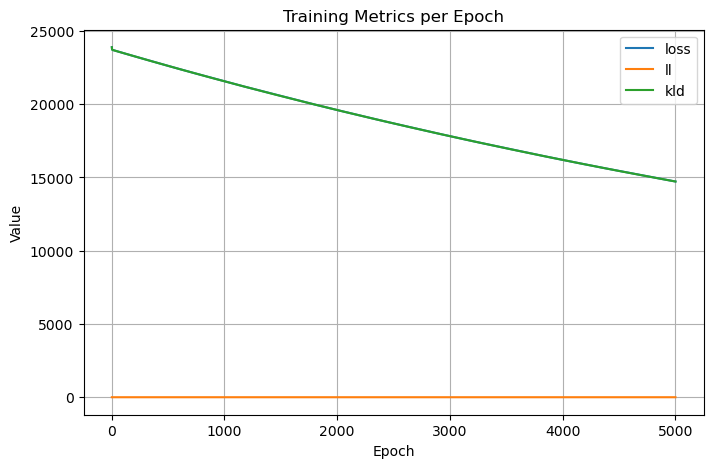

In [97]:
import matplotlib.pyplot as plt
import numpy as np

# Extract unique epochs
epochs = sorted(set(d['epoch'] for d in history))

# Compute average values per epoch
metrics = {m: [np.mean([d[m] for d in history if d['epoch'] == e]) for e in epochs] 
           for m in ['loss', 'll', 'kld']}

# Plot
plt.figure(figsize=(8, 5))
for metric, values in metrics.items():
    plt.plot(epochs, values, label=metric)

plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training Metrics per Epoch')
plt.legend()
plt.grid(True)
plt.show()


In [21]:
model

MixMIL(
  Q=50, K=1, P=1, likelihood=binomial, n_trials=1, device=cpu, trained=True
  (alpha): Parameter(shape=(1, 1))
  (log_sigma_u): Parameter(shape=(1, 1))
  (log_sigma_z): Parameter(shape=(1, 1))
  (posterior): GaussianVariationalPosterior(n_vars=2*50, n_outs=1, mean_field=False)
)

In [ ]:
# TODO: get a training curve here